Epoch 1/20, Loss: 1.2598, Train Accuracy: 63.16%, Val Accuracy: 69.46%
Epoch 2/20, Loss: 0.6474, Train Accuracy: 73.72%, Val Accuracy: 75.74%
Epoch 3/20, Loss: 0.5642, Train Accuracy: 77.96%, Val Accuracy: 78.18%
Epoch 4/20, Loss: 0.4682, Train Accuracy: 81.32%, Val Accuracy: 80.28%
Epoch 5/20, Loss: 0.3597, Train Accuracy: 86.77%, Val Accuracy: 78.71%
Epoch 6/20, Loss: 0.2560, Train Accuracy: 90.62%, Val Accuracy: 80.80%
Epoch 7/20, Loss: 0.1286, Train Accuracy: 95.42%, Val Accuracy: 77.31%
Epoch 8/20, Loss: 0.0812, Train Accuracy: 97.95%, Val Accuracy: 79.58%
Epoch 9/20, Loss: 0.0677, Train Accuracy: 98.34%, Val Accuracy: 71.90%
Epoch 10/20, Loss: 0.0700, Train Accuracy: 98.04%, Val Accuracy: 81.50%
Epoch 11/20, Loss: 0.0463, Train Accuracy: 99.00%, Val Accuracy: 80.10%
Epoch 12/20, Loss: 0.0887, Train Accuracy: 97.34%, Val Accuracy: 80.63%
Epoch 13/20, Loss: 0.0543, Train Accuracy: 98.82%, Val Accuracy: 79.23%
Epoch 14/20, Loss: 0.0539, Train Accuracy: 98.52%, Val Accuracy: 80.98%
E

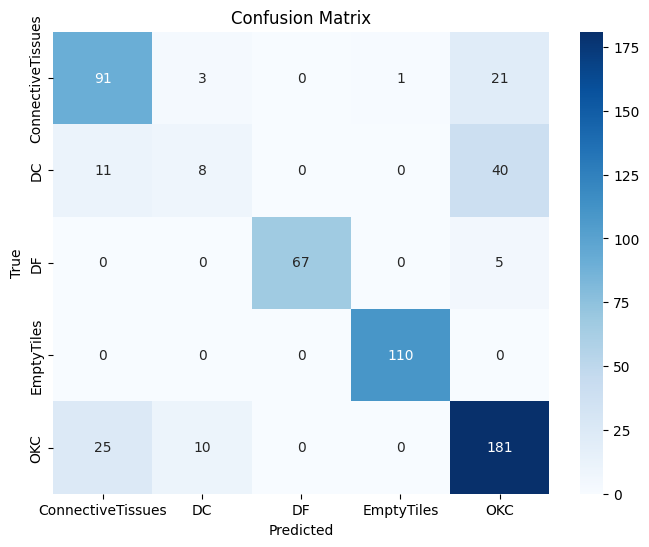

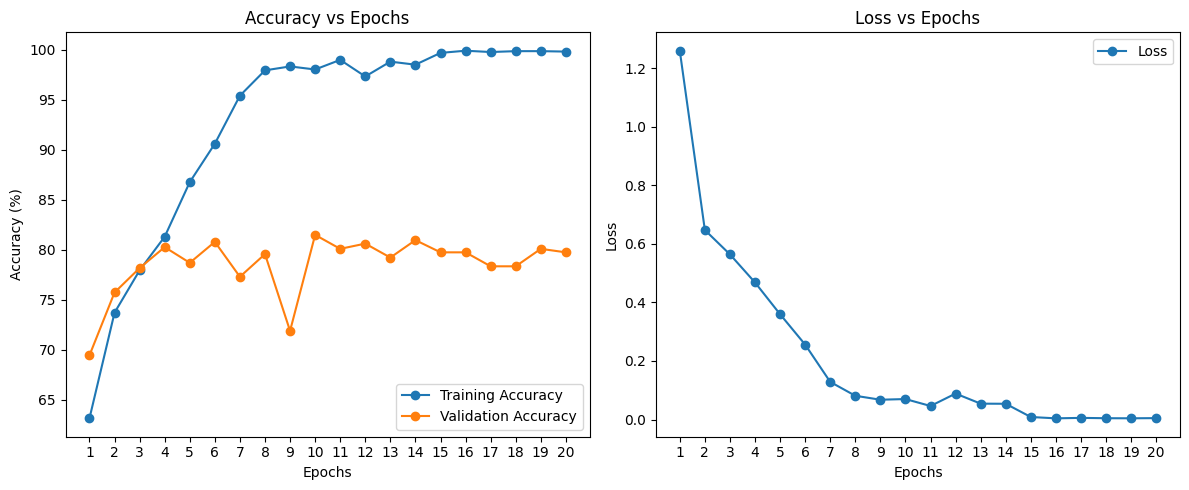

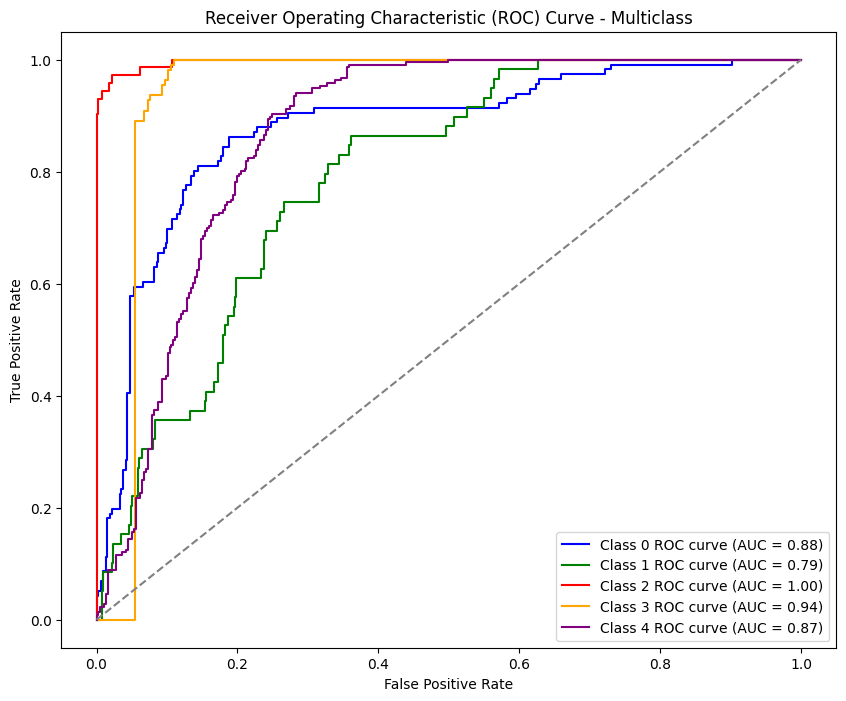

AUC for Class 0: 0.8775
AUC for Class 1: 0.7922
AUC for Class 2: 0.9969
AUC for Class 3: 0.9423
AUC for Class 4: 0.8679


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Custom HyperComplex Layers
class HyperComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(HyperComplexConv2d, self).__init__()
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    
    def forward(self, x):
        real = self.conv_r(x)
        imag = self.conv_i(x)
        return torch.cat([real, imag], dim=1)  # Concatenate along channel dimension

class HyperComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(HyperComplexLinear, self).__init__()
        self.fc_r = nn.Linear(in_features, out_features)
        self.fc_i = nn.Linear(in_features, out_features)
    
    def forward(self, x):
        real = self.fc_r(x)
        imag = self.fc_i(x)
        return torch.cat([real, imag], dim=1)  # Concatenate along feature dimension

# HyperComplexCNN Model
class HyperComplexCNN(nn.Module):
    def __init__(self, input_channels=2, num_classes=2):
        super(HyperComplexCNN, self).__init__()
        self.conv1 = HyperComplexConv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = HyperComplexConv2d(32, 32, kernel_size=3, stride=1, padding=1)  # Adjusted input channels
        self.fc1 = HyperComplexLinear(32 * 56 * 56 * 2, 256)  # Account for doubled channels
        self.fc2 = HyperComplexLinear(256 * 2, num_classes)  # Account for doubled features
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Output channels = 16 * 2 = 32
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))  # Output channels = 32 * 2 = 64
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten for linear layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data Preparation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x], dim=0))  # Duplicate to create 2 channels
])

dataset = datasets.ImageFolder(r"D:\Project Main\dataset", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HyperComplexCNN(input_channels=2, num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Function with Accuracy Calculation
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_accuracies = []
    val_accuracies = []
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        losses.append(epoch_loss)

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

    return train_accuracies, val_accuracies, losses

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    y_scores = []  # For ROC Curve
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())  # Save raw scores for ROC curve
    return y_true, y_pred, y_scores

# Training and Validation
train_accuracies, val_accuracies, losses = train_model(model, criterion, optimizer, train_loader, test_loader)

# Testing
y_true, y_pred, y_scores = evaluate_model(model, test_loader)

# Performance Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot Accuracy and Loss over 20 Epochs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_accuracies, marker='o', label='Training Accuracy')  # Add markers for clarity
plt.plot(range(1, 21), val_accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, 21))  # Ensure all 20 epochs are shown
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), losses, marker='o', label='Loss')  # Add markers for clarity
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21))  # Ensure all 20 epochs are shown
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


# Binarize the labels for one-vs-rest ROC
n_classes = len(set(y_true))  # Number of classes
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], [score[i] for score in y_scores])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Adjust for the number of classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], 
             label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multiclass')
plt.legend(loc='lower right')
plt.show()

# Print AUC values for each class
for i in range(n_classes):
    print(f"AUC for Class {i}: {roc_auc[i]:.4f}")


c:\environ\cuda\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Loss: 1.4556, Val Loss: 0.9000, Train Accuracy: 55.44%, Val Accuracy: 63.40%
Epoch 2/20, Loss: 0.8306, Val Loss: 0.7630, Train Accuracy: 63.17%, Val Accuracy: 69.70%
Epoch 3/20, Loss: 0.7499, Val Loss: 0.7030, Train Accuracy: 67.07%, Val Accuracy: 68.07%
Epoch 4/20, Loss: 0.7095, Val Loss: 0.8865, Train Accuracy: 71.01%, Val Accuracy: 59.21%
Epoch 5/20, Loss: 0.6743, Val Loss: 0.6811, Train Accuracy: 73.15%, Val Accuracy: 72.73%
Epoch 6/20, Loss: 0.6169, Val Loss: 0.5598, Train Accuracy: 75.25%, Val Accuracy: 77.16%
Epoch 7/20, Loss: 0.6263, Val Loss: 0.5673, Train Accuracy: 75.15%, Val Accuracy: 76.92%
Epoch 8/20, Loss: 0.5990, Val Loss: 0.6141, Train Accuracy: 75.80%, Val Accuracy: 75.76%
Epoch 9/20, Loss: 0.5832, Val Loss: 0.5335, Train Accuracy: 76.85%, Val Accuracy: 79.72%
Epoch 10/20, Loss: 0.5865, Val Loss: 0.5746, Train Accuracy: 75.80%, Val Accuracy: 78.79%
Epoch 11/20, Loss: 0.5531, Val Loss: 0.6107, Train Accuracy: 78.39%, Val Accuracy: 75.52%
Epoch 12/20, Loss: 

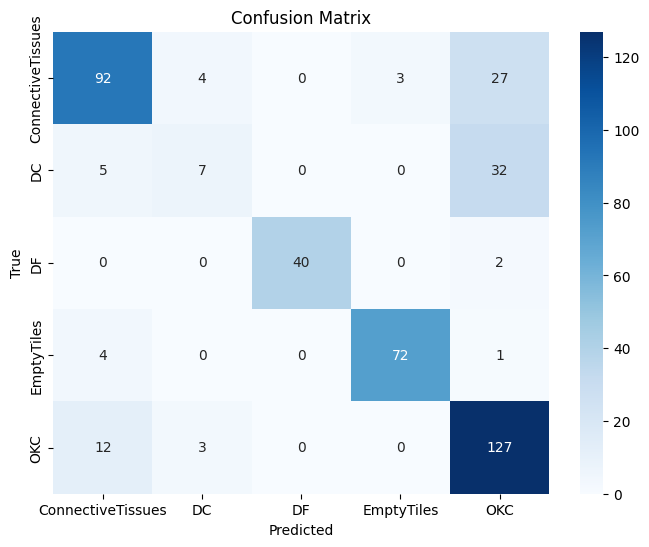

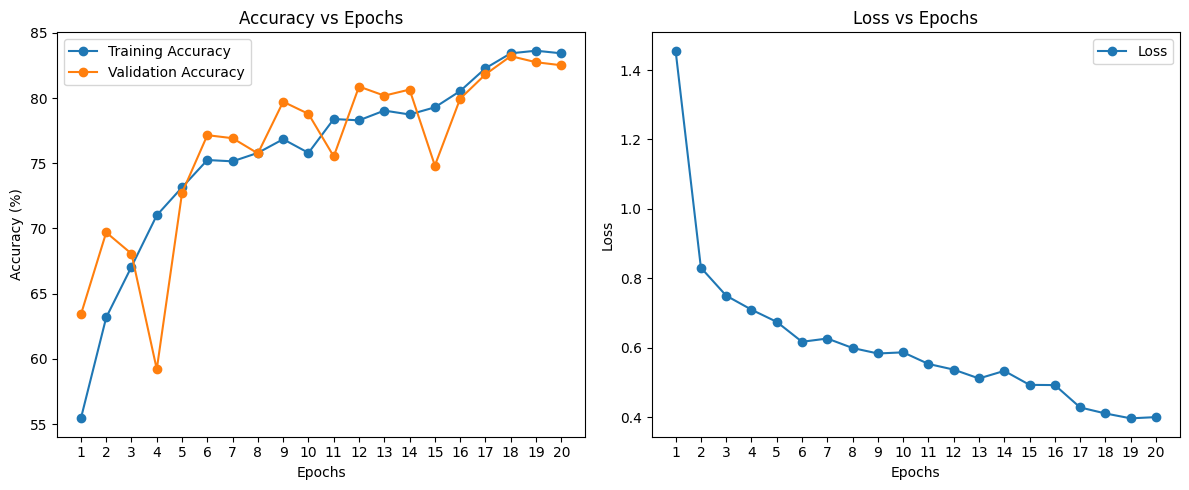

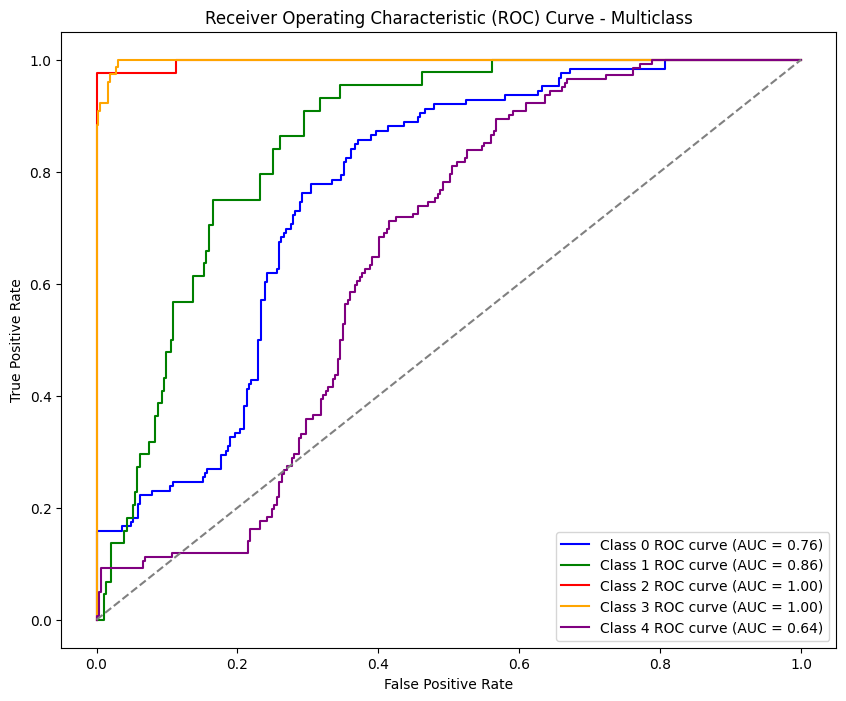

AUC for Class 0: 0.7621
AUC for Class 1: 0.8559
AUC for Class 2: 0.9973
AUC for Class 3: 0.9982
AUC for Class 4: 0.6439


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Custom HyperComplex Layers
class HyperComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(HyperComplexConv2d, self).__init__()
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    
    def forward(self, x):
        real = self.conv_r(x)
        imag = self.conv_i(x)
        return torch.cat([real, imag], dim=1)  # Concatenate along channel dimension

class HyperComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(HyperComplexLinear, self).__init__()
        self.fc_r = nn.Linear(in_features, out_features)
        self.fc_i = nn.Linear(in_features, out_features)
    
    def forward(self, x):
        real = self.fc_r(x)
        imag = self.fc_i(x)
        return torch.cat([real, imag], dim=1)  # Concatenate along feature dimension

# HyperComplexCNN Model
class HyperComplexCNN(nn.Module):
    def __init__(self, input_channels=2, num_classes=2):
        super(HyperComplexCNN, self).__init__()
        self.conv1 = HyperComplexConv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = HyperComplexConv2d(32, 32, kernel_size=3, stride=1, padding=1)  # Adjusted input channels
        self.fc1 = HyperComplexLinear(32 * 56 * 56 * 2, 256)  # Account for doubled channels
        self.dropout = nn.Dropout(0.5)  # Add dropout
        self.fc2 = HyperComplexLinear(256 * 2, num_classes)  # Account for doubled features
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Output channels = 16 * 2 = 32
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))  # Output channels = 32 * 2 = 64
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten for linear layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

# Data Preparation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x], dim=0))  # Duplicate to create 2 channels
])

dataset = datasets.ImageFolder(r"D:\Project Main\dataset", transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HyperComplexCNN(input_channels=2, num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)  # Learning rate scheduler

# Training and Validation Function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_accuracies = []
    val_accuracies = []
    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        losses.append(epoch_loss)

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        val_loss /= len(val_loader)
        val_accuracies.append(val_accuracy)

        # Step the scheduler
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

    return train_accuracies, val_accuracies, losses

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    y_scores = []  # For ROC Curve
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())  # Save raw scores for ROC curve
    return y_true, y_pred, y_scores

# Training and Validation
train_accuracies, val_accuracies, losses = train_model(model, criterion, optimizer, train_loader, val_loader)

# Testing
y_true, y_pred, y_scores = evaluate_model(model, test_loader)

# Performance Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Plot Accuracy and Loss over 20 Epochs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_accuracies, marker='o', label='Training Accuracy')  # Add markers for clarity
plt.plot(range(1, 21), val_accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, 21))  # Ensure all 20 epochs are shown
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), losses, marker='o', label='Loss')  # Add markers for clarity
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21))  # Ensure all 20 epochs are shown
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


# Binarize the labels for one-vs-rest ROC
n_classes = len(set(y_true))  # Number of classes
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], [score[i] for score in y_scores])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Adjust for the number of classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], 
             label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multiclass')
plt.legend(loc='lower right')
plt.show()

# Print AUC values for each class
for i in range(n_classes):
    print(f"AUC for Class {i}: {roc_auc[i]:.4f}")

Epoch 1/20
Train Loss: 0.8830, Train Accuracy: 63.82%
Val Loss: 0.7865, Val Accuracy: 73.43%
------------------------------------------------------------
Epoch 2/20
Train Loss: 0.7109, Train Accuracy: 71.56%
Val Loss: 0.8369, Val Accuracy: 64.69%
------------------------------------------------------------
Epoch 3/20
Train Loss: 0.6584, Train Accuracy: 73.90%
Val Loss: 0.6218, Val Accuracy: 73.43%
------------------------------------------------------------
Epoch 4/20
Train Loss: 0.6239, Train Accuracy: 75.45%
Val Loss: 0.6630, Val Accuracy: 70.63%
------------------------------------------------------------
Epoch 5/20
Train Loss: 0.5710, Train Accuracy: 76.90%
Val Loss: 0.5891, Val Accuracy: 75.52%
------------------------------------------------------------
Epoch 6/20
Train Loss: 0.5537, Train Accuracy: 77.94%
Val Loss: 0.4998, Val Accuracy: 77.97%
------------------------------------------------------------
Epoch 7/20
Train Loss: 0.5290, Train Accuracy: 79.74%
Val Loss: 0.5455, Val 

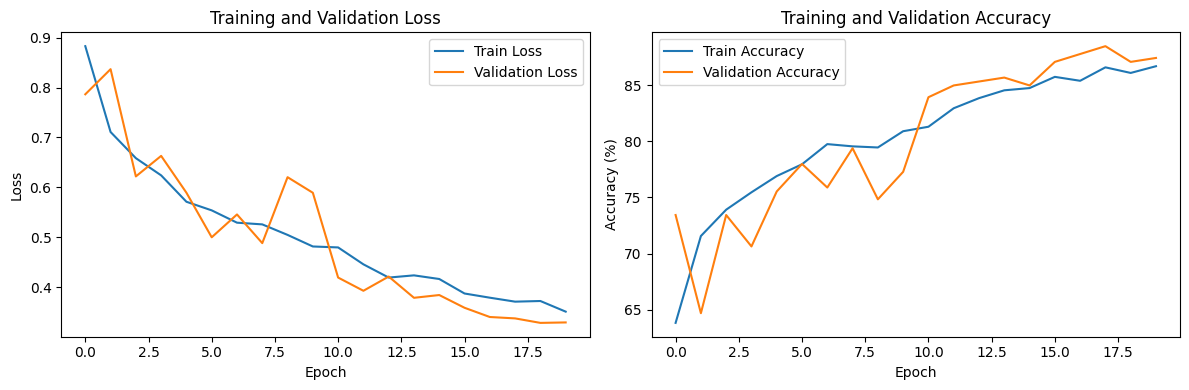

C:\Users\Infinity M10\AppData\Local\Temp\ipykernel_13792\3372260829.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Classification Report:
                   precision    recall  f1-score   support

ConnectiveTissues       0.86      0.82      0.84       133
               DC       0.76      0.62      0.68        60
               DF       0.96      1.00      0.98        71
       EmptyTiles       0.97      1.00      0.99       107
              OKC       0.84      0.89      0.86       203

         accuracy                           0.88       574
        macro avg       0.88      0.86      0.87       574
     weighted avg       0.88      0.88      0.88       574



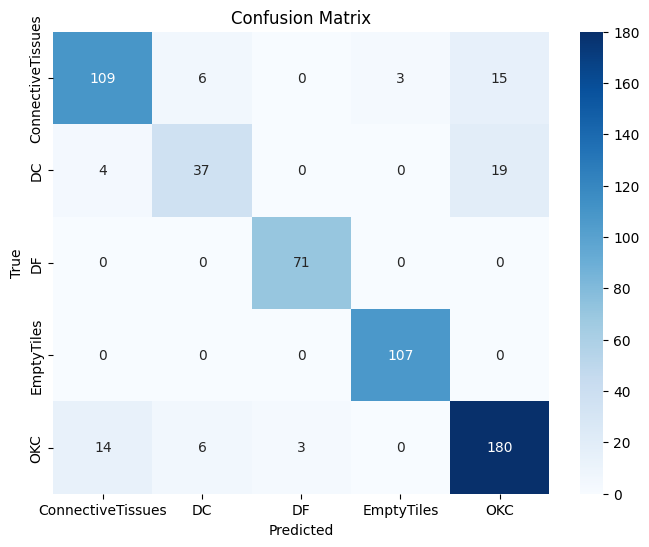

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Optimized HyperComplexConv2D Layer
class HyperComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(HyperComplexConv2d, self).__init__()
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv_i = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels * 2)  # Batch Normalization for stability

    def forward(self, x):
        real = self.conv_r(x)
        imag = self.conv_i(x)
        out = torch.cat([real, imag], dim=1)  # Concatenate along channel dimension
        return self.bn(F.relu(out))  # Apply activation and batch normalization

# Optimized HyperComplexCNN Model
class HyperComplexCNN(nn.Module):
    def __init__(self, input_channels=2, num_classes=2):
        super(HyperComplexCNN, self).__init__()
        self.conv1 = HyperComplexConv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = HyperComplexConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = HyperComplexConv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive Pooling to reduce feature size
        self.fc1 = nn.Linear(64 * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        x = self.conv1(x)  # Output: 32 channels
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)  # Output: 64 channels
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv3(x)  # Output: 128 channels
        x = self.pool(x)  # Output: 1x1 spatial dimensions
        x = x.view(x.size(0), -1)  # Flatten for linear layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data Preparation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x], dim=0))  # Duplicate to create 2 channels
])

dataset = datasets.ImageFolder(r"D:\\Project Main\\dataset", transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HyperComplexCNN(input_channels=2, num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Function with Validation
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=20):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        print("-" * 60)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

# Training and Testing
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=20
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
y_true, y_pred = evaluate_model(model, test_loader)

# Performance Metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Dataset Statistics:
--------------------------------------------------
Total number of classes: 5

Class names and their indices:
Class: ConnectiveTissues (Index: 0)
  Training samples: 461
  Validation samples: 75
  Testing samples: 133
Class: DC (Index: 1)
  Training samples: 180
  Validation samples: 35
  Testing samples: 60
Class: DF (Index: 2)
  Training samples: 206
  Validation samples: 30
  Testing samples: 71
Class: EmptyTiles (Index: 3)
  Training samples: 372
  Validation samples: 49
  Testing samples: 107
Class: OKC (Index: 4)
  Training samples: 785
  Validation samples: 97
  Testing samples: 203

Total samples in each split:
Training: 2004
Validation: 286
Testing: 574


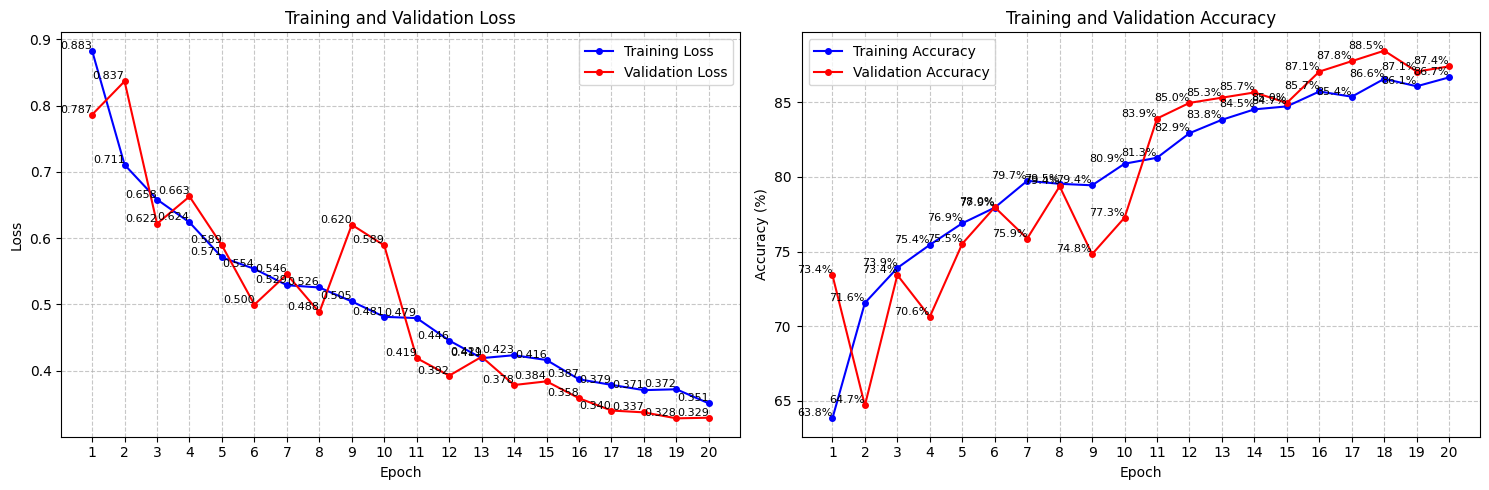

C:\Users\Infinity M10\AppData\Local\Temp\ipykernel_13792\1976878619.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_classes))


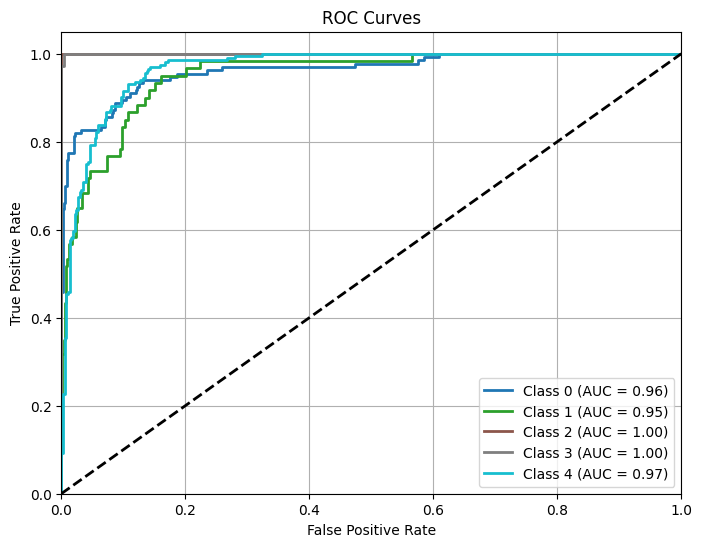

In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter

# Print dataset statistics
def print_dataset_stats(dataset, train_dataset, val_dataset, test_dataset):
    # Get class names and total counts
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Count samples in each split
    train_targets = [dataset.targets[i] for i in train_dataset.indices]
    val_targets = [dataset.targets[i] for i in val_dataset.indices]
    test_targets = [dataset.targets[i] for i in test_dataset.indices]
    
    # Count samples per class in each split
    train_counts = Counter(train_targets)
    val_counts = Counter(val_targets)
    test_counts = Counter(test_targets)
    
    print("\nDataset Statistics:")
    print("-" * 50)
    print(f"Total number of classes: {len(dataset.classes)}")
    print("\nClass names and their indices:")
    for class_name, idx in class_to_idx.items():
        print(f"Class: {class_name} (Index: {idx})")
        print(f"  Training samples: {train_counts[idx]}")
        print(f"  Validation samples: {val_counts[idx]}")
        print(f"  Testing samples: {test_counts[idx]}")
    
    print("\nTotal samples in each split:")
    print(f"Training: {len(train_dataset)}")
    print(f"Validation: {len(val_dataset)}")
    print(f"Testing: {len(test_dataset)}")

# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss', markersize=4)
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss', markersize=4)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Show all epochs
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Annotate values for each epoch
    for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
        plt.text(epochs[i], train_loss, f'{train_loss:.3f}', 
                verticalalignment='bottom', horizontalalignment='right', fontsize=8)
        plt.text(epochs[i], val_loss, f'{val_loss:.3f}', 
                verticalalignment='bottom', horizontalalignment='right', fontsize=8)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy', markersize=4)
    plt.plot(epochs, val_accuracies, 'r-o', label='Validation Accuracy', markersize=4)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)  # Show all epochs
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Annotate values for each epoch
    for i, (train_acc, val_acc) in enumerate(zip(train_accuracies, val_accuracies)):
        plt.text(epochs[i], train_acc, f'{train_acc:.1f}%', 
                verticalalignment='bottom', horizontalalignment='right', fontsize=8)
        plt.text(epochs[i], val_acc, f'{val_acc:.1f}%', 
                verticalalignment='bottom', horizontalalignment='right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Plot ROC curve and calculate AUC
def plot_roc_curve(model, test_loader, device, num_classes):
    model.eval()
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_classes))
    
    for i in range(num_classes):
        # Convert to binary classification problem for each class
        y_true_binary = (y_true == i).astype(int)
        y_score = y_scores[:, i]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Usage example (add after training):
print_dataset_stats(dataset, train_dataset, val_dataset, test_dataset)
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
plot_roc_curve(model, test_loader, device, len(dataset.classes))